# Búsqueda Tabú

Se implementará la versión de BT utilizando una lista de movimientos tabú y tres estrategias de reinicialización.Sus principales características son:
* Estrategia de selección de vecino: Consistirá en examinar 40 vecinos para cogerel mejor de acuerdo a los criterios tabú.
* Selección  de  estrategias  de reinicialización:  La  probabilidad  de  escoger  lareinicialización construyendo una solución inicial aleatoria es 0,25, la de usar lamemoria a largo plazo al generar una nueva solución greedy es 0,5, y la deutilizar la reinicialización desde la mejor solución obtenidaes 0,25.
* Además de saltar a una solución concreta según las reinicializaciones comentadas, también  se  alterará  un  parámetro  del  algoritmo  de  búsqueda  para  provocar  un cambio de comportamiento del algoritmo más efectivo. Este consistirá en variar el tamaño de la lista tabú, incrementándola o reduciéndola en un 50% según una decisión aleatoria uniforme. 
 
El número máximo de iteraciones en total, incluyendo las reinicializaciones, será de 40 · n. Se realizarán 4 reinicializaciones, es decir, una cada 8 · n iteraciones.  

El tamaño inicial   de   cada   lista   tabú   será n=2,   estos   valores   cambiarán   después   de   las reinicializaciones según se ha comentado.Dado el carácter probabilístico del algoritmo, deberá ejecutarse 10 veces (con semillas distintas para el generador aleatorio, para cada caso del problema (dataset).

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import busqueda_tabu

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.
- agregar_resultados(dataframe,nombre,result): guarda los resultados de la ejecución en el dataframe según la plantilla del pdf.

In [2]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [3]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [4]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [5]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [6]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):


        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

In [7]:
def agregar_resultados(dataframe,nombre,result):

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"Coste")] = result[i][1]

    dataframe.loc["Media",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"Coste")] = resultados.loc[:"Ejecución 10",(nombre,"Coste")].std()

    for i in range(10):
        dataframe.loc["Ejecución "+str(i+1),(nombre,"#Ev")] = result[i][2]

    dataframe.loc["Media",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].mean()
    dataframe.loc["Des. Tip. (s)",(nombre,"#Ev")] = resultados.loc[:"Ejecución 10",(nombre,"#Ev")].std()

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [8]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [9]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [10]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[275380, 304941, 256806, 45831, 118167, 391806, 55926, 102005, 284668, 453186]


## Dataframe para ver los resultados

In [11]:
mux = pd.MultiIndex.from_product([["St70","Ch130","A280","Pa654","Vm1084","Vm1748"], ['Coste','#Ev']])
resultados = pd.DataFrame(
    columns=mux,
    index = ['Ejecución 1', 'Ejecución 2', 'Ejecución 3',"Ejecución 4","Ejecución 5","Ejecución 6","Ejecución 7","Ejecución 8","Ejecución 9","Ejecución 10","Media","Des. Tip. (s)"]
)

#### st70

,Semilla,Coste,Nº de evaluaciones
0,275380.0,917.0,112004.0
1,304941.0,945.0,112005.0
2,256806.0,1016.0,112005.0
3,45831.0,958.0,112005.0
4,118167.0,1025.0,112005.0
5,391806.0,1017.0,112004.0
6,55926.0,947.0,112005.0
7,102005.0,1054.0,112005.0
8,284668.0,989.0,112005.0
9,453186.0,1030.0,112004.0


Media coste:  989.8
Desviación típica coste:  45.40386669779471
Media nº de evaluaciones:  112004.7
Desviación típica nº de evaluaciones:  0.48304589153964794

Representación de la mejor solución: 


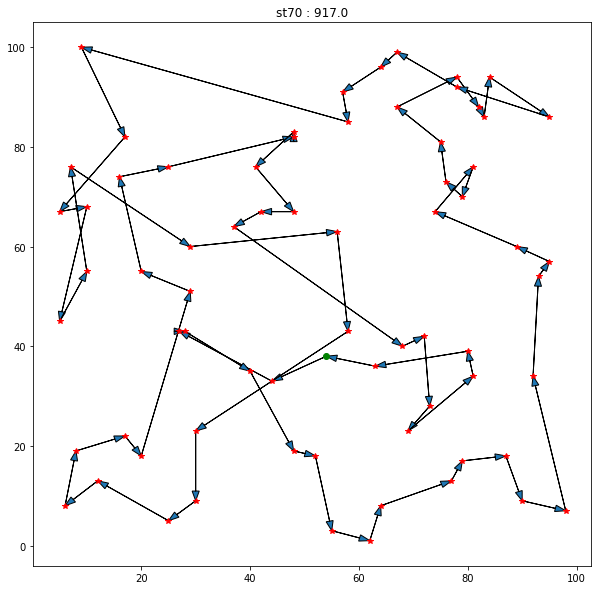

In [12]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
representacion_datos(result,"st70")

agregar_resultados(resultados,"St70",result)

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,275380.0,12077.0,208003.0
1,304941.0,12743.0,208004.0
2,256806.0,11899.0,208005.0
3,45831.0,11839.0,208004.0
4,118167.0,12011.0,208004.0
5,391806.0,12045.0,208005.0
6,55926.0,11410.0,208005.0
7,102005.0,12745.0,208003.0
8,284668.0,12632.0,208005.0
9,453186.0,12130.0,208004.0


Media coste:  12153.1
Desviación típica coste:  432.2163681408756
Media nº de evaluaciones:  208004.2
Desviación típica nº de evaluaciones:  0.7888106377466155

Representación de la mejor solución: 


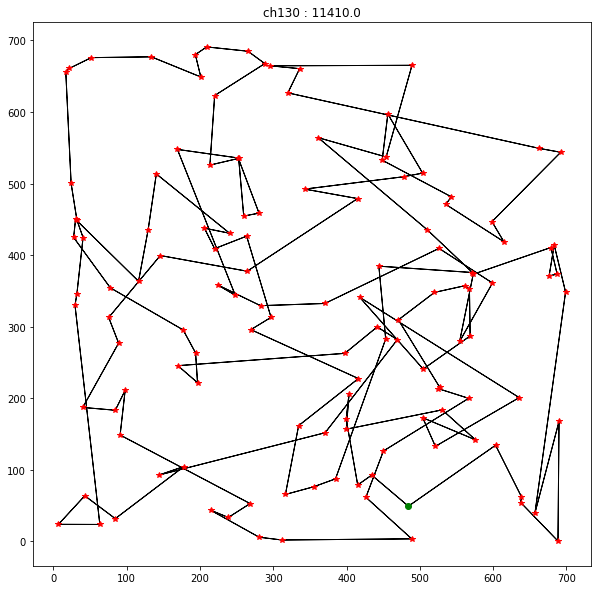

In [13]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"ch130")

agregar_resultados(resultados,"Ch130",result)

#### a280

,Semilla,Coste,Nº de evaluaciones
0,275380.0,3608.0,448004.0
1,304941.0,3437.0,448004.0
2,256806.0,3808.0,448004.0
3,45831.0,4476.0,448004.0
4,118167.0,2958.0,448004.0
5,391806.0,2981.0,448002.0
6,55926.0,3174.0,448005.0
7,102005.0,3131.0,448003.0
8,284668.0,3050.0,448004.0
9,453186.0,3519.0,448004.0


Media coste:  3414.2
Desviación típica coste:  471.15456298567483
Media nº de evaluaciones:  448003.8
Desviación típica nº de evaluaciones:  0.7888106377466155

Representación de la mejor solución: 


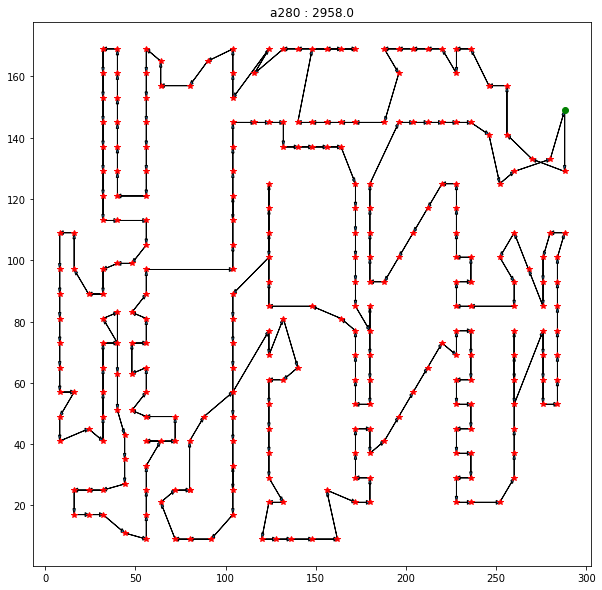

In [14]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )

representacion_datos(result,"a280")

agregar_resultados(resultados,"A280",result)

#### p654

,Semilla,Coste,Nº de evaluaciones
0,275380.0,108314.0,1046404.0
1,304941.0,115325.0,1046404.0
2,256806.0,117860.0,1046403.0
3,45831.0,314913.0,1046402.0
4,118167.0,107548.0,1046403.0
5,391806.0,108225.0,1046403.0
6,55926.0,112117.0,1046404.0
7,102005.0,112916.0,1046404.0
8,284668.0,125439.0,1046403.0
9,453186.0,114279.0,1046404.0


Media coste:  133693.6
Desviación típica coste:  63898.59050471215
Media nº de evaluaciones:  1046403.4
Desviación típica nº de evaluaciones:  0.699205898780101

Representación de la mejor solución: 


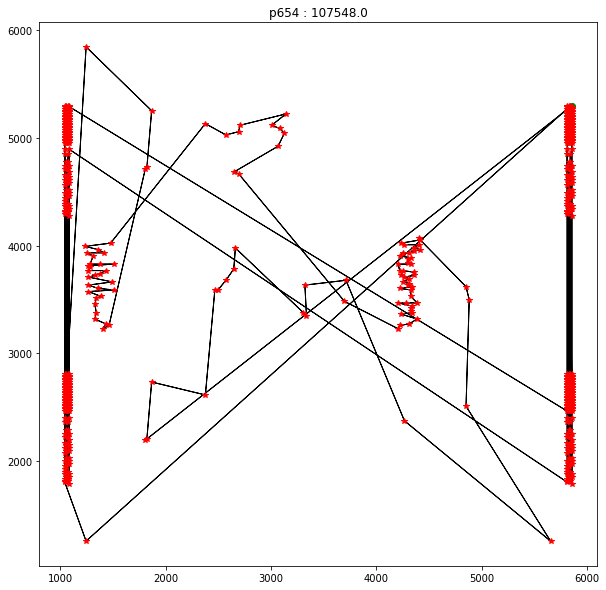

In [15]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"p654")

agregar_resultados(resultados,"Pa654",result)

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,275380.0,1895994.0,1734404.0
1,304941.0,1798970.0,1734405.0
2,256806.0,1819991.0,1734405.0
3,45831.0,1783636.0,1734403.0
4,118167.0,1826971.0,1734404.0
5,391806.0,1746576.0,1734404.0
6,55926.0,1827573.0,1734404.0
7,102005.0,1864948.0,1734404.0
8,284668.0,1720909.0,1734405.0
9,453186.0,1777668.0,1734405.0


Media coste:  1806323.6
Desviación típica coste:  52490.87380826838
Media nº de evaluaciones:  1734404.3
Desviación típica nº de evaluaciones:  0.674948557710553

Representación de la mejor solución: 


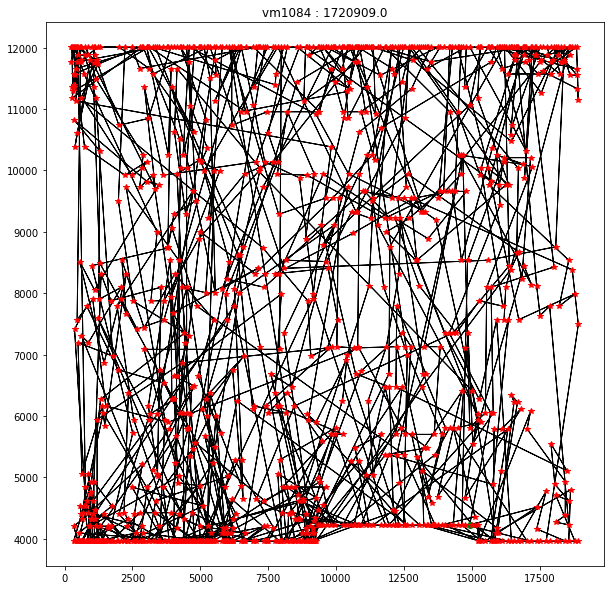

In [16]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1084")

agregar_resultados(resultados,"Vm1084",result)

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,275380.0,3451142.0,2796803.0
1,304941.0,3289001.0,2796805.0
2,256806.0,3429481.0,2796803.0
3,45831.0,3203343.0,2796805.0
4,118167.0,3455187.0,2796804.0
5,391806.0,3317904.0,2796803.0
6,55926.0,3422040.0,2796804.0
7,102005.0,3183965.0,2796803.0
8,284668.0,3263407.0,2796805.0
9,453186.0,3198021.0,2796804.0


Media coste:  3321349.1
Desviación típica coste:  110058.1419911514
Media nº de evaluaciones:  2796803.9
Desviación típica nº de evaluaciones:  0.8755950357709131

Representación de la mejor solución: 


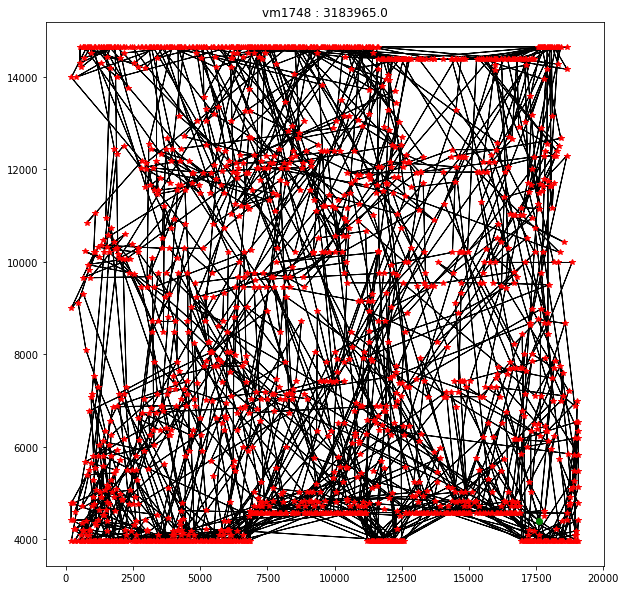

In [17]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1748")

agregar_resultados(resultados,"Vm1748",result)

---
# Resultados

In [18]:
resultados

St70                 Ch130                  A280  \
                   Coste       #Ev       Coste       #Ev       Coste   
Ejecución 1        917.0    112004     12077.0    208003      3608.0   
Ejecución 2        945.0    112005     12743.0    208004      3437.0   
Ejecución 3       1016.0    112005     11899.0    208005      3808.0   
Ejecución 4        958.0    112005     11839.0    208004      4476.0   
Ejecución 5       1025.0    112005     12011.0    208004      2958.0   
Ejecución 6       1017.0    112004     12045.0    208005      2981.0   
Ejecución 7        947.0    112005     11410.0    208005      3174.0   
Ejecución 8       1054.0    112005     12745.0    208003      3131.0   
Ejecución 9        989.0    112005     12632.0    208005      3050.0   
Ejecución 10      1030.0    112004     12130.0    208004      3519.0   
Media              989.8  112004.7     12153.1  208004.2      3414.2   
Des. Tip. (s)  45.403867  0.483046  432.216368  0.788811  471.154563   

                                Pa654                   Vm1084             \
                    #Ev         Coste        #Ev         Coste        #Ev   
Ejecución 1      448004      108314.0    1046404     1895994.0    1734404   
Ejecución 2      448004      115325.0    1046404     1798970.0    1734405   
Ejecución 3      448004      117860.0    1046403     1819991.0    1734405   
Ejecución 4      448004      314913.0    1046402     1783636.0    1734403   
Ejecución 5      448004      107548.0    1046403     1826971.0    1734404   
Ejecución 6      448002      108225.0    1046403     1746576.0    1734404   
Ejecución 7      448005      112117.0    1046404     1827573.0    1734404   
Ejecución 8      448003      112916.0    1046404     1864948.0    1734404   
Ejecución 9      448004      125439.0    1046403     1720909.0    1734405   
Ejecución 10     448004      114279.0    1046404     1777668.0    1734405   
Media          448003.8      133693.6  1046403.4     1806323.6  1734404.3   
Des. Tip. (s)  0.788811  63898.590505   0.699206  52490.873808   0.674949   

                      Vm1748             
                       Coste        #Ev  
Ejecución 1        3451142.0    2796803  
Ejecución 2        3289001.0    2796805  
Ejecución 3        3429481.0    2796803  
Ejecución 4        3203343.0    2796805  
Ejecución 5        3455187.0    2796804  
Ejecución 6        3317904.0    2796803  
Ejecución 7        3422040.0    2796804  
Ejecución 8        3183965.0    2796803  
Ejecución 9        3263407.0    2796805  
Ejecución 10       3198021.0    2796804  
Media              3321349.1  2796803.9  
Des. Tip. (s)  110058.141991   0.875595

In [19]:
resultados.to_csv(r'./Resultados.csv')